# What is the impact of resampling on correlation coefficients?

[Eggebrecht et al. (2017)](https://doi.org/10.1093/cercor/bhw403) and [Feczko et al. (2021)](https://doi.org/10.1101/2021.07.09.451638) calculate correlation matrices from trimmed time series, which only contain a specified amount of time. I would like to dig into this approach.

My concern is that the variance of the trimmed correlation coefficients may swamp any benefits from trimming. Additionally, I want to ensure that the trimmed correlation coefficients exhibit a nonlinear relationship (or any relationship) with motion.

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def subsampling_analysis(df, n_volumes_to_retain, n_iters, node1, node2, fd=None):
    """Subsample two time series to calculate a set of trimmed correlation coefficients.
    
    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame with at least two columns, and one row for each volume.
    n_volumes_to_retain : int
        The number of volumes to retain in each iteration.
    n_iters : int
        The number of iterations.
    node1, node2 : str
        The names of the columns in df to correlate.
    fd : None or numpy.ndarray, optional
        Optional framewise displacement values.
        If set to None, the resampling will use a uniform probability distribution.
        If provided, the resampling will weight lower FD values more highly, 
        making them more likely to be selected in the subsampled time series.
        Must be the same length as df.
    
    Returns
    -------
    true_z : float
        The Fisher's z value for the correlation between the full (un-trimmed) time series.
    subsampled_zs : numpy.ndarray
        Fisher's z values for the correlations of the subsampled time series.
        One value for each iteration.
    """
    if fd is not None:
        assert df.shape[0] == fd.shape[0]
        fd_weights = np.abs(fd - np.max(fd))
        fd_weights /= np.sum(fd_weights)
    else:
        fd_weights = None

    volume_idx = list(range(df.shape[0]))
    subsampled_correlations = np.empty(n_iters)

    # Limit the time series to a single, arbitrary pair of nodes to reduce computation time
    df = df[[node1, node2]]
    true_correlation = df.corr().loc[node1, node2]

    for seed in range(n_iters):
        rng = np.random.default_rng(seed)
        random_censor = sorted(rng.choice(volume_idx, size=n_volumes_to_retain, replace=False, p=fd_weights))
        # Apply the random censor and calculate the correlation coefficient
        temp_df = df.loc[random_censor]
        temp_corr_df = temp_df.corr()
        subsampled_correlations[seed] = temp_corr_df.loc[node1, node2]

    true_z = np.arctanh(true_correlation)
    subsampled_zs = np.arctanh(subsampled_correlations)

    return true_z, subsampled_zs

## Prepare basic subsampling analysis

In [3]:
node1, node2 = "Right_V1", "Right_MST"
n_iters = 10000

# Retain 5 minutes of data
n_minutes_to_retain = 5
t_r = 2
n_volumes_to_retain = int((60 * n_minutes_to_retain) / t_r)

xcp_d_dir = "/Users/taylor/Documents/datasets/ds003643/derivatives/xcp_d/sub-EN100/func"
timeseries_file = os.path.join(
    xcp_d_dir,
    "sub-EN100_task-lppEN_space-MNI152NLin6Asym_atlas-Glasser_timeseries.tsv",
)
timeseries_df = pd.read_table(timeseries_file)

confounds_file = os.path.join(xcp_d_dir, "sub-EN100_task-lppEN_motion.tsv")
confounds_df = pd.read_table(confounds_file)
fd = confounds_df["framewise_displacement"]

outliers_file = os.path.join(xcp_d_dir, "sub-EN100_task-lppEN_outliers.tsv")
outliers_df = pd.read_table(outliers_file)
retain_idx = outliers_df.loc[outliers_df["framewise_displacement"] == 0].index.values
assert fd.shape[0] == outliers_df.shape[0]
fd = fd[retain_idx]
print( fd.shape[0])

1084


<ipython-input-4-48876c1fd95a>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


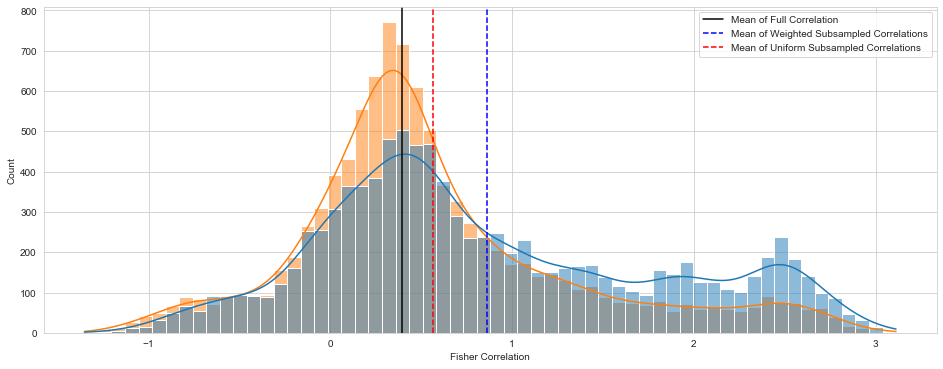

In [4]:
true_z, subsampled_zs_weighted = subsampling_analysis(
    timeseries_df,
    n_volumes_to_retain,
    n_iters,
    node1,
    node2,
    fd=fd,
)
_, subsampled_zs_uniform = subsampling_analysis(
    timeseries_df,
    n_volumes_to_retain,
    n_iters,
    node1,
    node2,
    fd=None,
)

mean_subsampled_zs_weighted = np.mean(subsampled_zs_weighted)
mean_subsampled_zs_uniform = np.mean(subsampled_zs_uniform)

z_df1 = pd.DataFrame(
    columns=["Z", "Iteration"],
    data=np.stack((subsampled_zs_weighted, np.arange(n_iters)), axis=1)
)
z_df1["Weighting"] = "Weighted"
z_df2 = pd.DataFrame(
    columns=["Z", "Iteration"],
    data=np.stack((subsampled_zs_uniform, np.arange(n_iters)), axis=1)
)
z_df2["Weighting"] = "Uniform"
z_df = pd.concat((z_df1, z_df2))

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(data=z_df, x="Z", hue="Weighting", kde=True)
ax.axvline(true_z, color="black", label="Mean of Full Correlation")
ax.axvline(
    mean_subsampled_zs_weighted,
    color="blue",
    linestyle="--",
    label="Mean of Weighted Subsampled Correlations",
)
ax.axvline(
    mean_subsampled_zs_uniform,
    color="red",
    linestyle="--",
    label="Mean of Uniform Subsampled Correlations",
)
ax.set_xlabel("Fisher Correlation")
ax.legend()
fig.show()

## What about the amount of time?

Does the amount of time retained affect the distribution of correlation coefficients?

At least in this case, the mean shifts higher when fewer volumes are retained.

<ipython-input-5-bfd37290054d>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


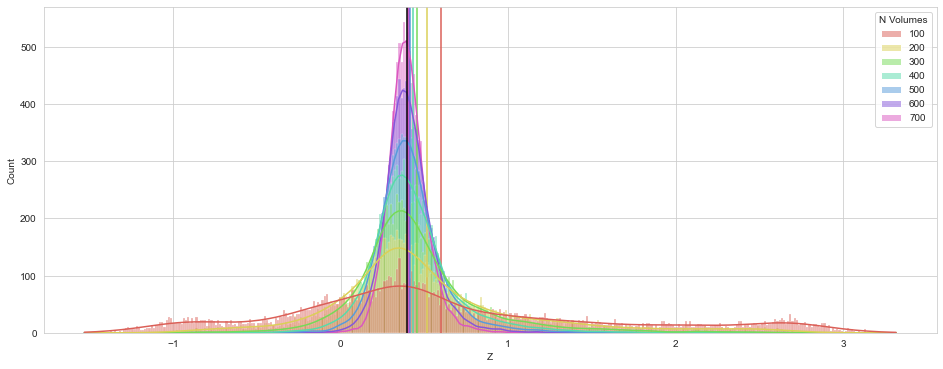

In [5]:
dfs = []

n_vols_to_run = [100, 200, 300, 400, 500, 600, 700, 800]
pal = sns.color_palette("hls", len(n_vols_to_run))

fig, ax = plt.subplots(figsize=(16, 6))
for i_vols, n_vols in enumerate(n_vols_to_run):
    _, subsampled_zs_uniform = subsampling_analysis(
        timeseries_df,
        n_vols,
        n_iters,
        node1,
        node2,
        fd=None,
    )
    temp_df = pd.DataFrame(
        columns=["Z", "Iteration"],
        data=np.stack((subsampled_zs_uniform, np.arange(n_iters)), axis=1)
    )
    temp_df["N Volumes"] = n_vols
    dfs.append(temp_df)
    ax.axvline(np.mean(subsampled_zs_uniform), label=f"Mean of {n_vols}", color=pal[i_vols])

concat_df = pd.concat(dfs)

sns.histplot(data=concat_df, x="Z", hue="N Volumes", kde=True, figure=fig, ax=ax, palette=pal)
ax.axvline(true_z, color="black", label="Mean of Full Correlation")
fig.show()

<ipython-input-6-fdb473f424a5>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


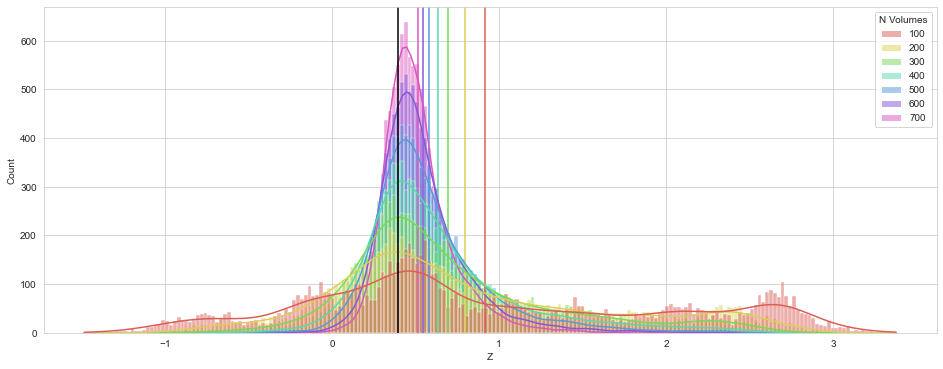

In [6]:
dfs = []

n_vols_to_run = [100, 200, 300, 400, 500, 600, 700, 800]
pal = sns.color_palette("hls", len(n_vols_to_run))

fig, ax = plt.subplots(figsize=(16, 6))
for i_vols, n_vols in enumerate(n_vols_to_run):
    _, subsampled_zs_weighted = subsampling_analysis(
        timeseries_df,
        n_vols,
        n_iters,
        node1,
        node2,
        fd=fd,
    )
    temp_df = pd.DataFrame(
        columns=["Z", "Iteration"],
        data=np.stack((subsampled_zs_weighted, np.arange(n_iters)), axis=1)
    )
    temp_df["N Volumes"] = n_vols
    dfs.append(temp_df)
    ax.axvline(np.mean(subsampled_zs_weighted), label=f"Mean of {n_vols}", color=pal[i_vols])

concat_df = pd.concat(dfs)

sns.histplot(data=concat_df, x="Z", hue="N Volumes", kde=True, figure=fig, ax=ax, palette=pal)
ax.axvline(true_z, color="black", label="Mean of Full Correlation")
fig.show()

## Look at patterns across participants

If we take the mean across many iterations, does the mean differ much from the full correlation? Is that correlated with the amount of data before random selection?

| X\Y | Full z | Mean subsampling z | Mean subsampling z - full z | Subsampling z skewness |
| :- | :- | :- | :- | :- |
| Number of high-motion outliers | . | . | . | . |
| Number of low-motion volumes | . | . | . | . |
| Mean FD | . | . | . | . |

1. Plot number of high-motion outlier volumes (or amount of data retained) against the difference between the mean z from subsampling analyses and true z from the full correlation.

2. Plot mean FD against the difference between the mean z from subsampling analyses and true z from the full correlation.

3. Plot number of high-motion outlier volumes (or amount of data retained) against a measure of skewness of the distributions of subsampled correlation coefficients.

4. Plot mean FD against a measure of skewness of the distributions of subsampled correlation coefficients.